In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [56]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import pathlib
import glob
from IPython.display import clear_output

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drive_path = '/content/drive/My Drive/Holmusk/'

In [5]:
cars_final = pd.read_csv(drive_path + 'data/train_final.csv')
cars_final.head()

,id,img,mask_file,rle_mask,year,make,model,trim1,trim2
0,00087a6bd4dc,00087a6bd4dc_01.jpg,00087a6bd4dc_01_mask.gif,879386 40 881253 141 883140 205 885009 17 8850...,2014.0,Acura,RLX,RLX,w/Tech
1,00087a6bd4dc,00087a6bd4dc_02.jpg,00087a6bd4dc_02_mask.gif,873779 4 875695 7 877612 9 879528 12 881267 15...,2014.0,Acura,RLX,RLX,w/Tech
2,00087a6bd4dc,00087a6bd4dc_03.jpg,00087a6bd4dc_03_mask.gif,864300 9 866217 13 868134 15 870051 16 871969 ...,2014.0,Acura,RLX,RLX,w/Tech
3,00087a6bd4dc,00087a6bd4dc_04.jpg,00087a6bd4dc_04_mask.gif,879735 20 881650 26 883315 92 883564 30 885208...,2014.0,Acura,RLX,RLX,w/Tech
4,00087a6bd4dc,00087a6bd4dc_05.jpg,00087a6bd4dc_05_mask.gif,883365 74 883638 28 885262 119 885550 34 88716...,2014.0,Acura,RLX,RLX,w/Tech


In [6]:
cars_final.shape

(5088, 9)

In [11]:
train, test = train_test_split(cars_final, random_state = 42)

In [12]:
train.shape

(3816, 9)

In [13]:
test.shape

(1272, 9)

In [7]:
image_URL = 'https://www.dropbox.com/s/nb40w6ajc8aqpm6/train.zip?dl=1'
image_path_to_zip = tf.keras.utils.get_file('train.zip', origin=image_URL, extract=True)
image_PATH = os.path.join(os.path.dirname(image_path_to_zip), 'train')

424239104/424233528 [==============================] - 3s 0us/step


In [8]:
image_PATH

'/root/.keras/datasets/train'

In [9]:
masks_URL = 'https://www.dropbox.com/s/h0yzq8mnay36cgc/train_masks.zip?dl=1'
masks_path_to_zip = tf.keras.utils.get_file('train_masks.zip', origin=masks_URL, extract=True)
masks_PATH = os.path.join(os.path.dirname(masks_path_to_zip), 'train_masks')

30539776/30537860 [==============================] - 0s 0us/step


In [10]:
masks_PATH

'/root/.keras/datasets/train_masks'

In [14]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 127.5
    return input_image, input_mask

In [15]:
def load_image_and_mask(image_filename, mask_filename):
    
    image_string = tf.io.read_file(image_filename)
    image_decoded = tf.io.decode_jpeg(image_string,channels = 3)
    input_image = tf.image.resize(image_decoded, (224, 224))
    
    mask_string = tf.io.read_file(mask_filename)
    mask_decoded = tf.io.decode_jpeg(mask_string, channels = 3)
    mask_grayscale = tf.image.rgb_to_grayscale(mask_decoded)
    input_mask = tf.image.resize(mask_grayscale, (224, 224))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [16]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [17]:
img_train = image_PATH + '/' + train['img']

In [18]:
mask_train = masks_PATH + '/' + train['mask_file']

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, mask_train))
train_dataset = train_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
img_test = image_PATH + '/' + test['img']

In [21]:
mask_test = masks_PATH + '/' + test['mask_file']

In [22]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, mask_test))
test_dataset = test_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [24]:
def display(display_list):
    
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()

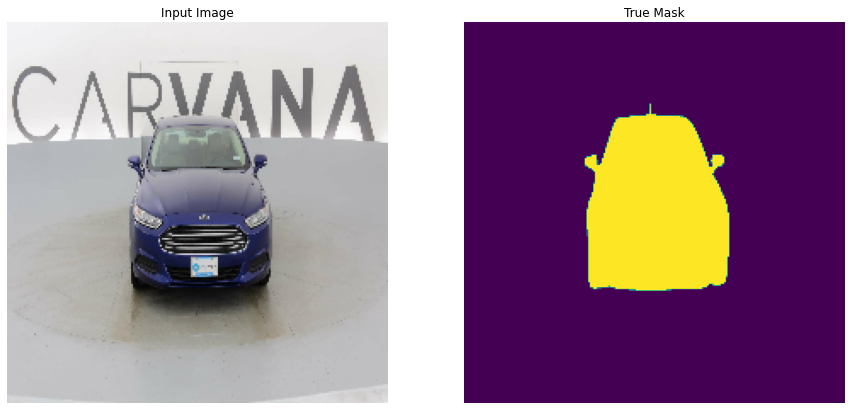

In [25]:
for image, mask in train_dataset.take(1):
    
    sample_image, sample_mask = image[1], mask[1]
    display([sample_image, sample_mask])

In [26]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   
    'block_3_expand_relu',   
    'block_6_expand_relu',   
    'block_13_expand_relu',
    'block_16_project',
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [27]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [40]:
up_stack = [
    pix2pix.upsample(576, 3),  
    pix2pix.upsample(192, 3),  
    pix2pix.upsample(144, 3),  
    pix2pix.upsample(96, 3),  
]

In [41]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #112x112 -> 224x224

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [57]:
OUTPUT_CHANNELS = 3

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

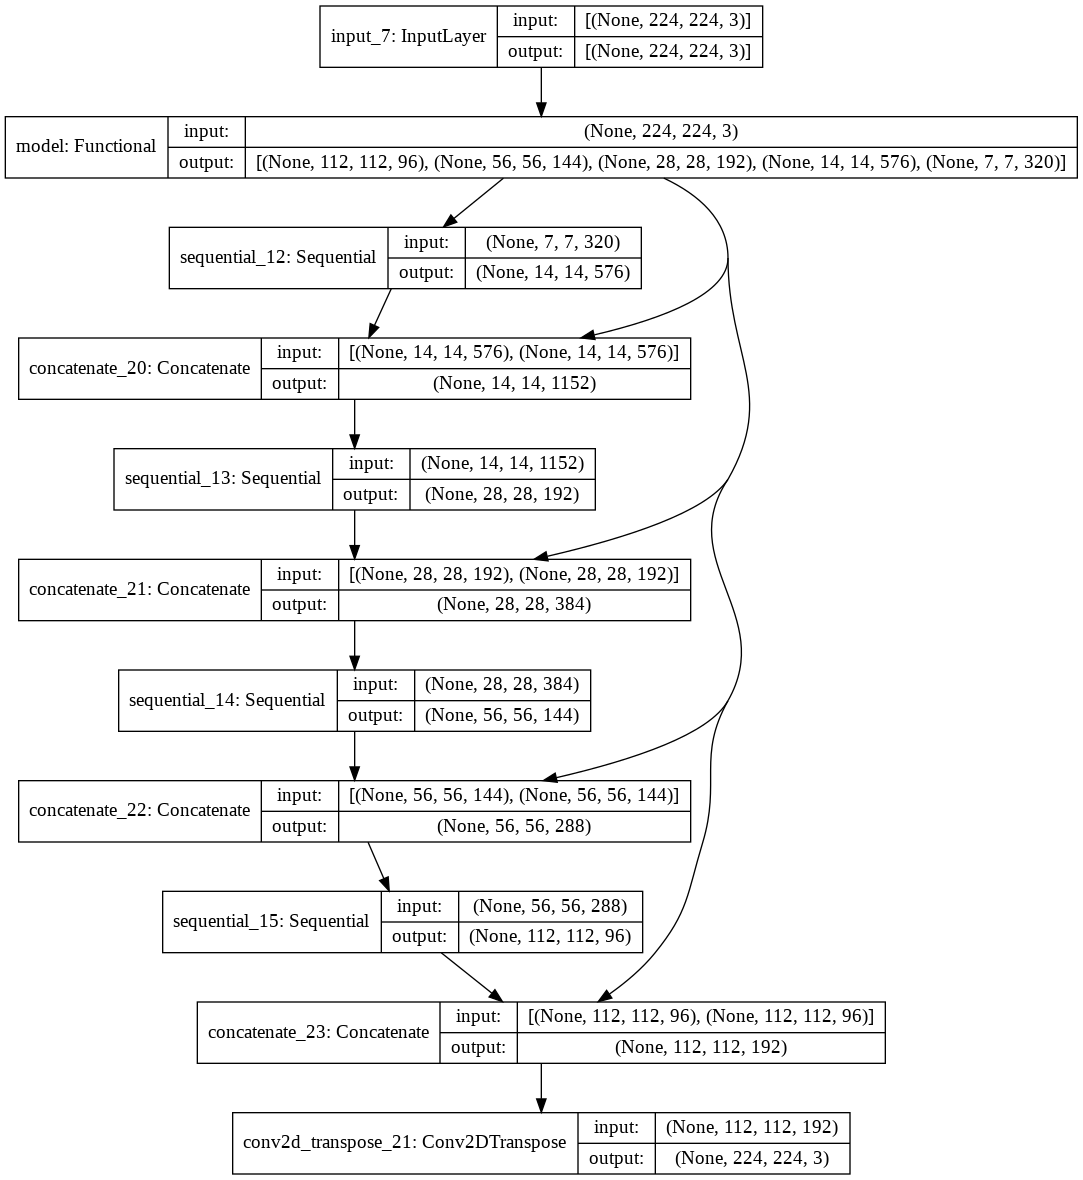

In [58]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [59]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [60]:
def show_predictions(dataset, num):

    for image, mask in dataset.take(num):
        
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask[0])])

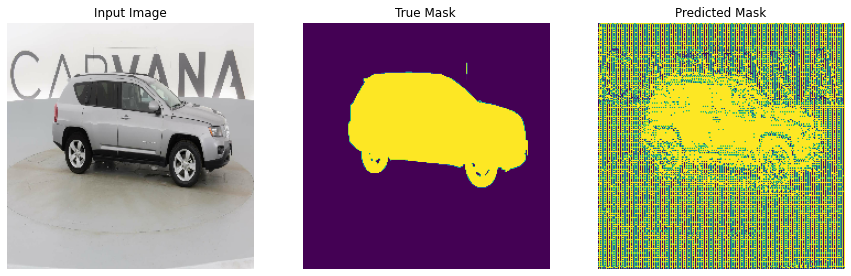

In [61]:
show_predictions(train_dataset, 1)

In [62]:
class DisplayCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        
        clear_output(wait=True)
        show_predictions(test_dataset, 1)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        
#creates a new class and function

In [64]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=4,
    min_delta=0.001,
    restore_best_weights=True)

In [65]:
EPOCHS = 15
TRAIN_LENGTH = train.shape[0]
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test.shape[0]//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[early_stopping])

Epoch 1/15
119/119 [==============================] - 32s 251ms/step - loss: 0.1846 - accuracy: 0.9341 - val_loss: 0.0248 - val_accuracy: 0.9916
Epoch 2/15
119/119 [==============================] - 29s 248ms/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.0187 - val_accuracy: 0.9934
Epoch 3/15
119/119 [==============================] - 29s 246ms/step - loss: 0.0151 - accuracy: 0.9947 - val_loss: 0.0173 - val_accuracy: 0.9936
Epoch 4/15
119/119 [==============================] - 29s 247ms/step - loss: 0.0139 - accuracy: 0.9949 - val_loss: 0.0161 - val_accuracy: 0.9940
Epoch 5/15
119/119 [==============================] - 30s 249ms/step - loss: 0.0134 - accuracy: 0.9950 - val_loss: 0.0156 - val_accuracy: 0.9942
Epoch 6/15
119/119 [==============================] - 30s 249ms/step - loss: 0.0128 - accuracy: 0.9952 - val_loss: 0.0153 - val_accuracy: 0.9943
Epoch 7/15
119/119 [==============================] - 30s 250ms/step - loss: 0.0122 - accuracy: 0.9954 - val_loss: 0.0153 - val_ac

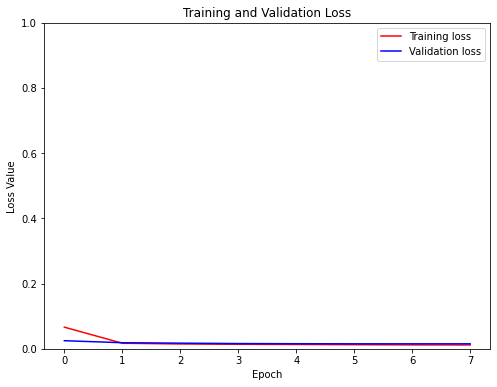

In [67]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure(figsize = (8, 6))
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

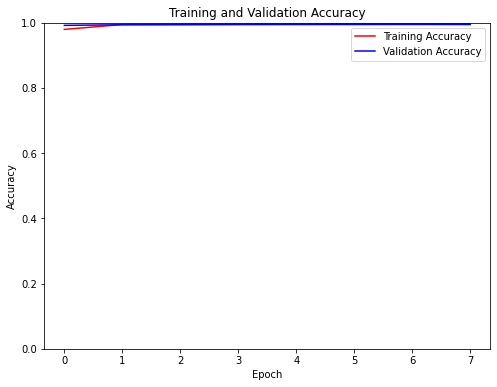

In [68]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

plt.figure(figsize = (8, 6))
plt.plot(accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [69]:
!pip install -q pyyaml h5py

In [70]:
model.save(drive_path + 'data/saved_model/Mobilenet_model.h5')

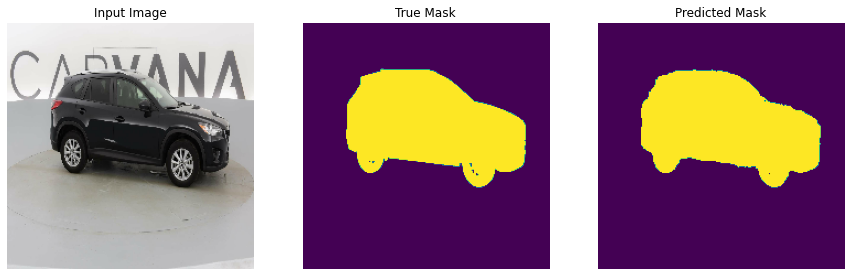

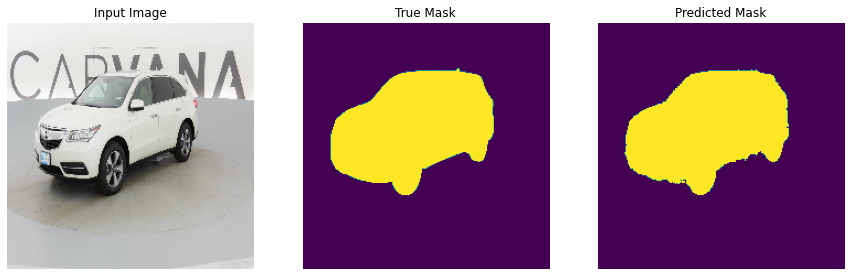

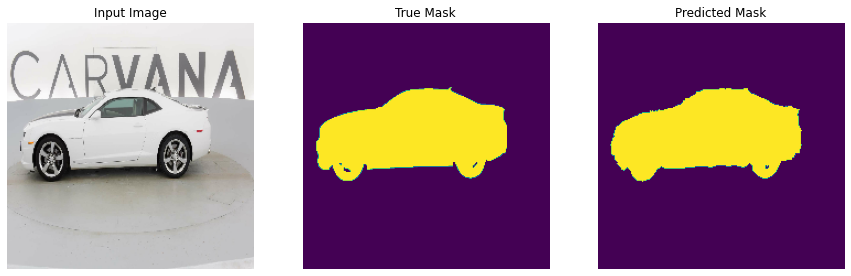

In [71]:
show_predictions(test_dataset, 3)